# ANALYSE DE DONNEE

## Contexe

L'objectif de cette mission est de réaliser une segmentation des clients d'Olist en utilisant des méthodes non supervisées, en se fondant sur des données anonymisées telles que l'historique des commandes, les produits achetés, les commentaires de satisfaction et la localisation des clients. Il s'agit de créer un modèle de segmentation exploitable par l'équipe Marketing, permettant de distinguer les clients en termes de commandes et de satisfaction. De plus, il est nécessaire de déterminer la fréquence optimale de mise à jour du modèle pour garantir sa pertinence dans le temps et de proposer un contrat de maintenance en conséquence. Le code développé doit être conforme à la convention PEP8 et être présenté à travers plusieurs documents.#

- Lignes et Colonnes : 116750, 25

- Types de variables : *object : 13 (52%), *float64 : 7 (28%), *int64 : 5 (20%)
                      


## IMPORTATION

In [1]:
#Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import seaborn as sns
import missingno as mno
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

#

In [3]:
Customers = pd.read_csv('olist_customers_dataset.csv')
Geolocalisation = pd.read_csv('olist_geolocation_dataset.csv')
Order_Items = pd.read_csv('olist_order_items_dataset.csv')
Order_Payments = pd.read_csv('olist_order_payments_dataset.csv')
Order_Reviews = pd.read_csv('olist_order_reviews_dataset.csv')
Orders = pd.read_csv('olist_orders_dataset.csv')
Products = pd.read_csv('olist_products_dataset.csv')
Sellers = pd.read_csv('olist_sellers_dataset.csv')
Translation = pd.read_csv('product_category_name_translation.csv')

In [4]:
from IPython.display import display, HTML

# Liste des noms des dataframes et leurs noms
dataframes = [
    (Customers, 'Customers'),
    (Geolocalisation, 'Geolocalisation'),
    (Order_Items, 'Order_Items'),
    (Order_Payments, 'Order_Payments'),
    (Order_Reviews, 'Order_Reviews'),
    (Orders, 'Orders'),
    (Products, 'Products'),
    (Sellers, 'Sellers'),
    (Translation, 'Translation')
]

# Créez une cellule HTML pour afficher les dataframes
html_content = "<table>"
for df, name in dataframes:
    html_content += f"<tr><td><strong>Dataframe: {name}</strong></td><td></td></tr>"
    html_content += f"<tr><td></td><td>{df.head().to_html()}</td></tr>"
html_content += "</table>"

# Affichez le contenu HTML
display(HTML(html_content))



# EXPLORATION ET NETTOYAGE DES DONNEES

######

In [5]:
import pandas as pd

def automate_data_merging(dataframes, key_columns, geolocation, translation_dict, columns_to_include):
    """
    Automatise le processus de fusion des données en suivant les étapes spécifiées.

    :param dataframes: Un dictionnaire contenant les DataFrames à fusionner.
    :param key_columns: Un dictionnaire contenant les colonnes clés pour chaque DataFrame.
    :param geolocation: Le DataFrame de géolocalisation.
    :param translation_dict: Dictionnaire de correspondance entre les noms portugais et anglais.
    :param columns_to_include: Liste des noms de colonnes à inclure dans le DataFrame final.

    :return: Le DataFrame fusionné.
    """
    
    # Étape 1 : Traduction des noms de catégories de produits
    dataframes['Products']['product_category_name'] = dataframes['Products']['product_category_name'].replace(translation_dict)
    
    # Étape 2 : Fusion avec les produits
    merged_data = dataframes['Order_Items'].merge(dataframes['Products'][['product_id', 'product_category_name']], on='product_id', how='inner')

    # Étape 3 : Fusion avec les paiements
    merged_data = merged_data.merge(dataframes['Order_Payments'].drop(columns=['payment_sequential']), on='order_id', how='inner')

    # Étape 4 : Fusion avec les commandes
    merged_data = merged_data.merge(dataframes['Orders'][['order_id', 'customer_id', 'order_approved_at']], on='order_id', how='inner')

    # Étape 5 : Fusion avec les clients
    merged_data = merged_data.merge(dataframes['Customers'], on='customer_id', how='inner')

    # Étape 6 : Fusion avec les avis sur les commandes
    merged_data = merged_data.merge(dataframes['Order_Reviews'][['order_id', 'review_score']], on='order_id', how='inner')

    # Étape 7 : Fusion avec les vendeurs
    merged_data = merged_data.merge(dataframes['Sellers'], on='seller_id', how='inner')

    # Étape 8 : Supprimer les doublons de Geolocalisation
    geolocation = geolocation.drop_duplicates(subset='geolocation_zip_code_prefix')

    # Étape 9 : Fusion des données des clients avec la géolocalisation
    merged_data = merged_data.merge(
        geolocation[['geolocation_lat', 'geolocation_lng', 'geolocation_zip_code_prefix']],
        left_on='customer_zip_code_prefix',
        right_on='geolocation_zip_code_prefix',
        how='inner'
    )

    # Étape 10 : Renommer les colonnes
    merged_data = merged_data.rename(columns={
        'geolocation_lat': 'customer_geo_lat',
        'geolocation_lng': 'customer_geo_lng'
    })

    # Étape 11 : Supprimer la colonne 'geolocation_zip_code_prefix'
    merged_data = merged_data.drop(columns=['geolocation_zip_code_prefix'], axis=1)

    # Étape 12 : Fusion des données des vendeurs avec la géolocalisation
    merged_data = merged_data.merge(
        geolocation[['geolocation_lat', 'geolocation_lng', 'geolocation_zip_code_prefix']],
        left_on='seller_zip_code_prefix',
        right_on='geolocation_zip_code_prefix',
        how='inner'
    )

    # Étape 13 : Renommer les colonnes
    merged_data = merged_data.rename(columns={
        'geolocation_lat': 'seller_geo_lat',
        'geolocation_lng': 'seller_geo_lng'
    })

    # Étape 14 : Supprimer la colonne 'geolocation_zip_code_prefix'
    merged_data = merged_data.drop(columns=['geolocation_zip_code_prefix'], axis=1)

    # Étape 15 : Sélection des colonnes à inclure
    if columns_to_include:
        merged_data = merged_data[columns_to_include]

    return merged_data

# Liste des DataFrames
dataframes = {
    'Order_Items': Order_Items,
    'Products': Products,
    'Order_Payments': Order_Payments,
    'Orders': Orders,
    'Customers': Customers,
    'Order_Reviews': Order_Reviews,
    'Sellers': Sellers
}

# Colonnes clés pour chaque fusion
key_columns = {
    'Products': 'product_id',
    'Order_Payments': 'order_id',
    'Orders': 'order_id',
    'Customers': 'customer_id',
    'Order_Reviews': 'order_id',
    'Sellers': 'seller_id'
}

# Appel de la fonction pour effectuer les fusions
translation_dict = dict(zip(Translation['product_category_name'], Translation['product_category_name_english']))
columns_to_include = None  # Spécifiez les colonnes à inclure si nécessaire
df = automate_data_merging(dataframes, key_columns, Geolocalisation, translation_dict, columns_to_include)


In [6]:
df.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

   shipping_limit_date  price  freight_value product_category_name  \
0  2017-09-19 09:45:35   58.9          13.29            cool_stuff   
1  2017-07-05 02:44:11   55.9          17.96            cool_stuff   
2  2018-05-23 10:56:25   64.9          18.33            cool_stuff   
3  2017-08-07 18:55:08   58.9          16.17            cool_stuff   
4  2017-08-16 22:05:11   58.9          13.29            cool_stuff   

  payment_type  payment_installments  payment_value  \
0  credit_card                     2          72.19   
1       boleto                     1          73.86   
2  credit_card                     2          83.23   
3  credit_card                     3          75.07   
4  credit_card                     4          72.19   

                        customer_id    order_approved_at  \
0  3ce436f183e68e07877b285a838db11a  2017-09-13 09:45:35   
1  e6eecc5a77de221464d1c4eaff0a9b64  2017-06-29 02:44:11   
2  4ef55bf80f711b372afebcb7c715344a  2018-05-18 12:31:43   
3  30407a72ad8b3f4df4d15369126b20c9  2017-08-01 18:55:08   
4  91a792fef70ecd8cc69d3c7feb3d12da  2017-08-10 22:05:11   

                 customer_unique_id  customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                     28013   
1  0fb8e3eab2d3e79d92bb3fffbb97f188                     75800   
2  3419052c8c6b45daf79c1e426f9e9bcb                     30720   
3  e7c828d22c0682c1565252deefbe334d                     83070   
4  0bb98ba72dcc08e95f9d8cc434e9a2cc                     36400   

           customer_city customer_state  review_score  seller_zip_code_prefix  \
0  campos dos goytacazes             RJ             5                   27277   
1                  jatai             GO             5                   27277   
2         belo horizonte             MG             4                   27277   
3   sao jose dos pinhais             PR             5                   27277   
4   conselheiro lafaiete             MG             5                   27277   

     seller_city seller_state  customer_geo_lat  customer_geo_lng  \
0  volta redonda           SP        -21.758076        -41.312633   
1  volta redonda           SP        -17.885607        -51.719640   
2  volta redonda           SP        -19.918025        -43.976133   
3  volta redonda           SP        -25.516321        -49.122818   
4  volta redonda           SP        -20.653542        -43.790837   

   seller_geo_lat  seller_geo_lng  
0      -22.498183      -44.123614  
1      -22.498183      -44.123614  
2      -22.498183      -44.123614  
3      -22.498183      -44.123614  
4      -22.498183      -44.123614

In [7]:
df.shape

(116750, 25)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116750 entries, 0 to 116749
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  116750 non-null  object 
 1   order_item_id             116750 non-null  int64  
 2   product_id                116750 non-null  object 
 3   seller_id                 116750 non-null  object 
 4   shipping_limit_date       116750 non-null  object 
 5   price                     116750 non-null  float64
 6   freight_value             116750 non-null  float64
 7   product_category_name     115062 non-null  object 
 8   payment_type              116750 non-null  object 
 9   payment_installments      116750 non-null  int64  
 10  payment_value             116750 non-null  float64
 11  customer_id               116750 non-null  object 
 12  order_approved_at         116735 non-null  object 
 13  customer_unique_id        116750 non-null  o

object     13
float64     7
int64       5
dtype: int64


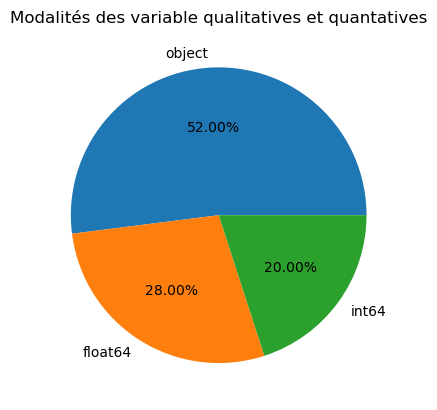

In [9]:
print(df.dtypes.value_counts())
df.dtypes.value_counts().plot.pie(autopct='%.2f%%')
plt.title('Modalités des variable qualitatives et quantatives')
pass

order_item_id          price  freight_value  payment_installments  \
count  116750.000000  116750.000000  116750.000000         116750.000000   
mean        1.194278     120.555497      20.020217              2.938552   
std         0.684986     183.147618      15.842486              2.774418   
min         1.000000       0.850000       0.000000              0.000000   
25%         1.000000      39.900000      13.070000              1.000000   
50%         1.000000      74.900000      16.270000              2.000000   
75%         1.000000     134.900000      21.180000              4.000000   
max        21.000000    6735.000000     409.680000             24.000000   

       payment_value  customer_zip_code_prefix   review_score  \
count  116750.000000              116750.00000  116750.000000   
mean      172.086640               34981.03564       4.031400   
std       265.719297               29836.66493       1.387984   
min         0.000000                1003.00000       1.000000   
25%        60.640000               11088.00000       4.000000   
50%       108.000000               24230.00000       5.000000   
75%       189.055000               58305.00000       5.000000   
max     13664.080000               99990.00000       5.000000   

       seller_zip_code_prefix  customer_geo_lat  customer_geo_lng  \
count           116750.000000     116750.000000     116750.000000   
mean             24459.378638        -21.235879        -46.199005   
std              27590.537524          5.574466          4.051692   
min               1001.000000        -36.605374        -72.666706   
25%               6440.000000        -23.590023        -48.105099   
50%              13660.000000        -22.930836        -46.632051   
75%              27930.000000        -20.196432        -43.627351   
max              99730.000000         42.184003         -8.577855   

       seller_geo_lat  seller_geo_lng  
count   116750.000000   116750.000000  
mean       -22.798950      -47.239053  
std          2.688791        2.341644  
min        -36.605374      -67.809656  
25%        -23.609316      -48.831547  
50%        -23.422076      -46.755211  
75%        -21.766477      -46.518082  
max         -2.546079      -34.847856

Total des valeurs non manquantes : 2917047 soit 99.94 %
Total des valeurs manquantes : 1703 soit 0.06 %

Pourcentage de valeurs manquantes par variable:
order_id                     0.0%
order_item_id                0.0%
product_id                   0.0%
seller_id                    0.0%
shipping_limit_date          0.0%
price                        0.0%
freight_value                0.0%
product_category_name       1.45%
payment_type                 0.0%
payment_installments         0.0%
payment_value                0.0%
customer_id                  0.0%
order_approved_at           0.01%
customer_unique_id           0.0%
customer_zip_code_prefix     0.0%
customer_city                0.0%
customer_state               0.0%
review_score                 0.0%
seller_zip_code_prefix       0.0%
seller_city                  0.0%
seller_state                 0.0%
customer_geo_lat             0.0%
customer_geo_lng             0.0%
seller_geo_lat               0.0%
seller_geo_lng               0.

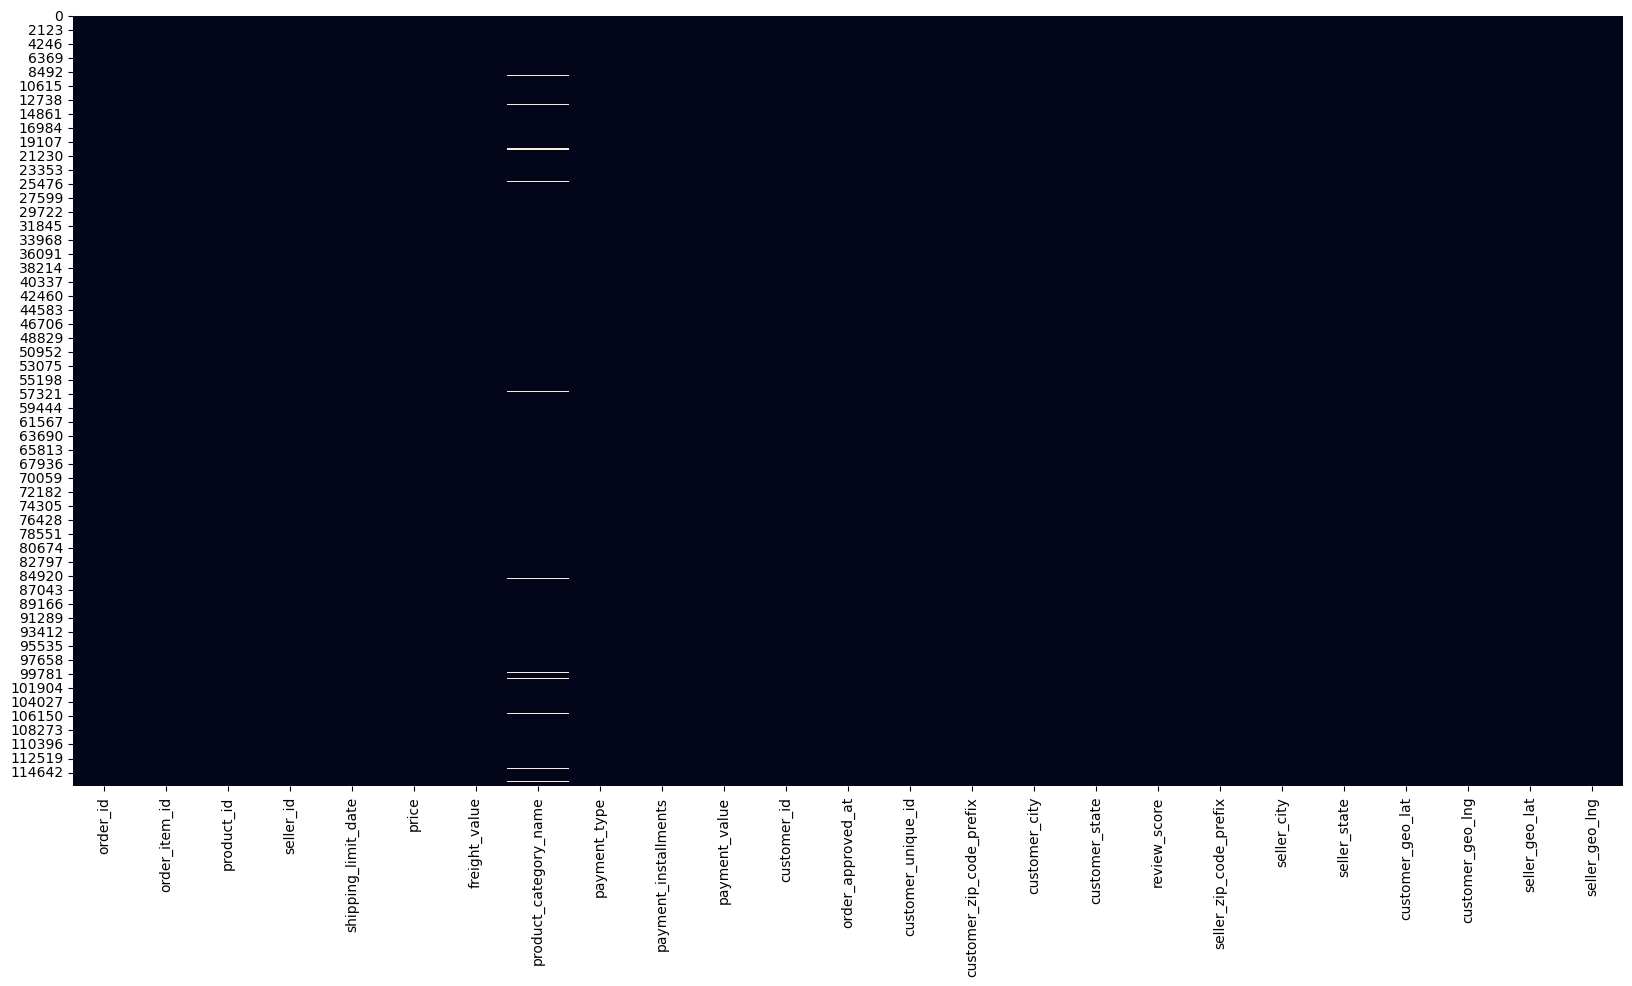

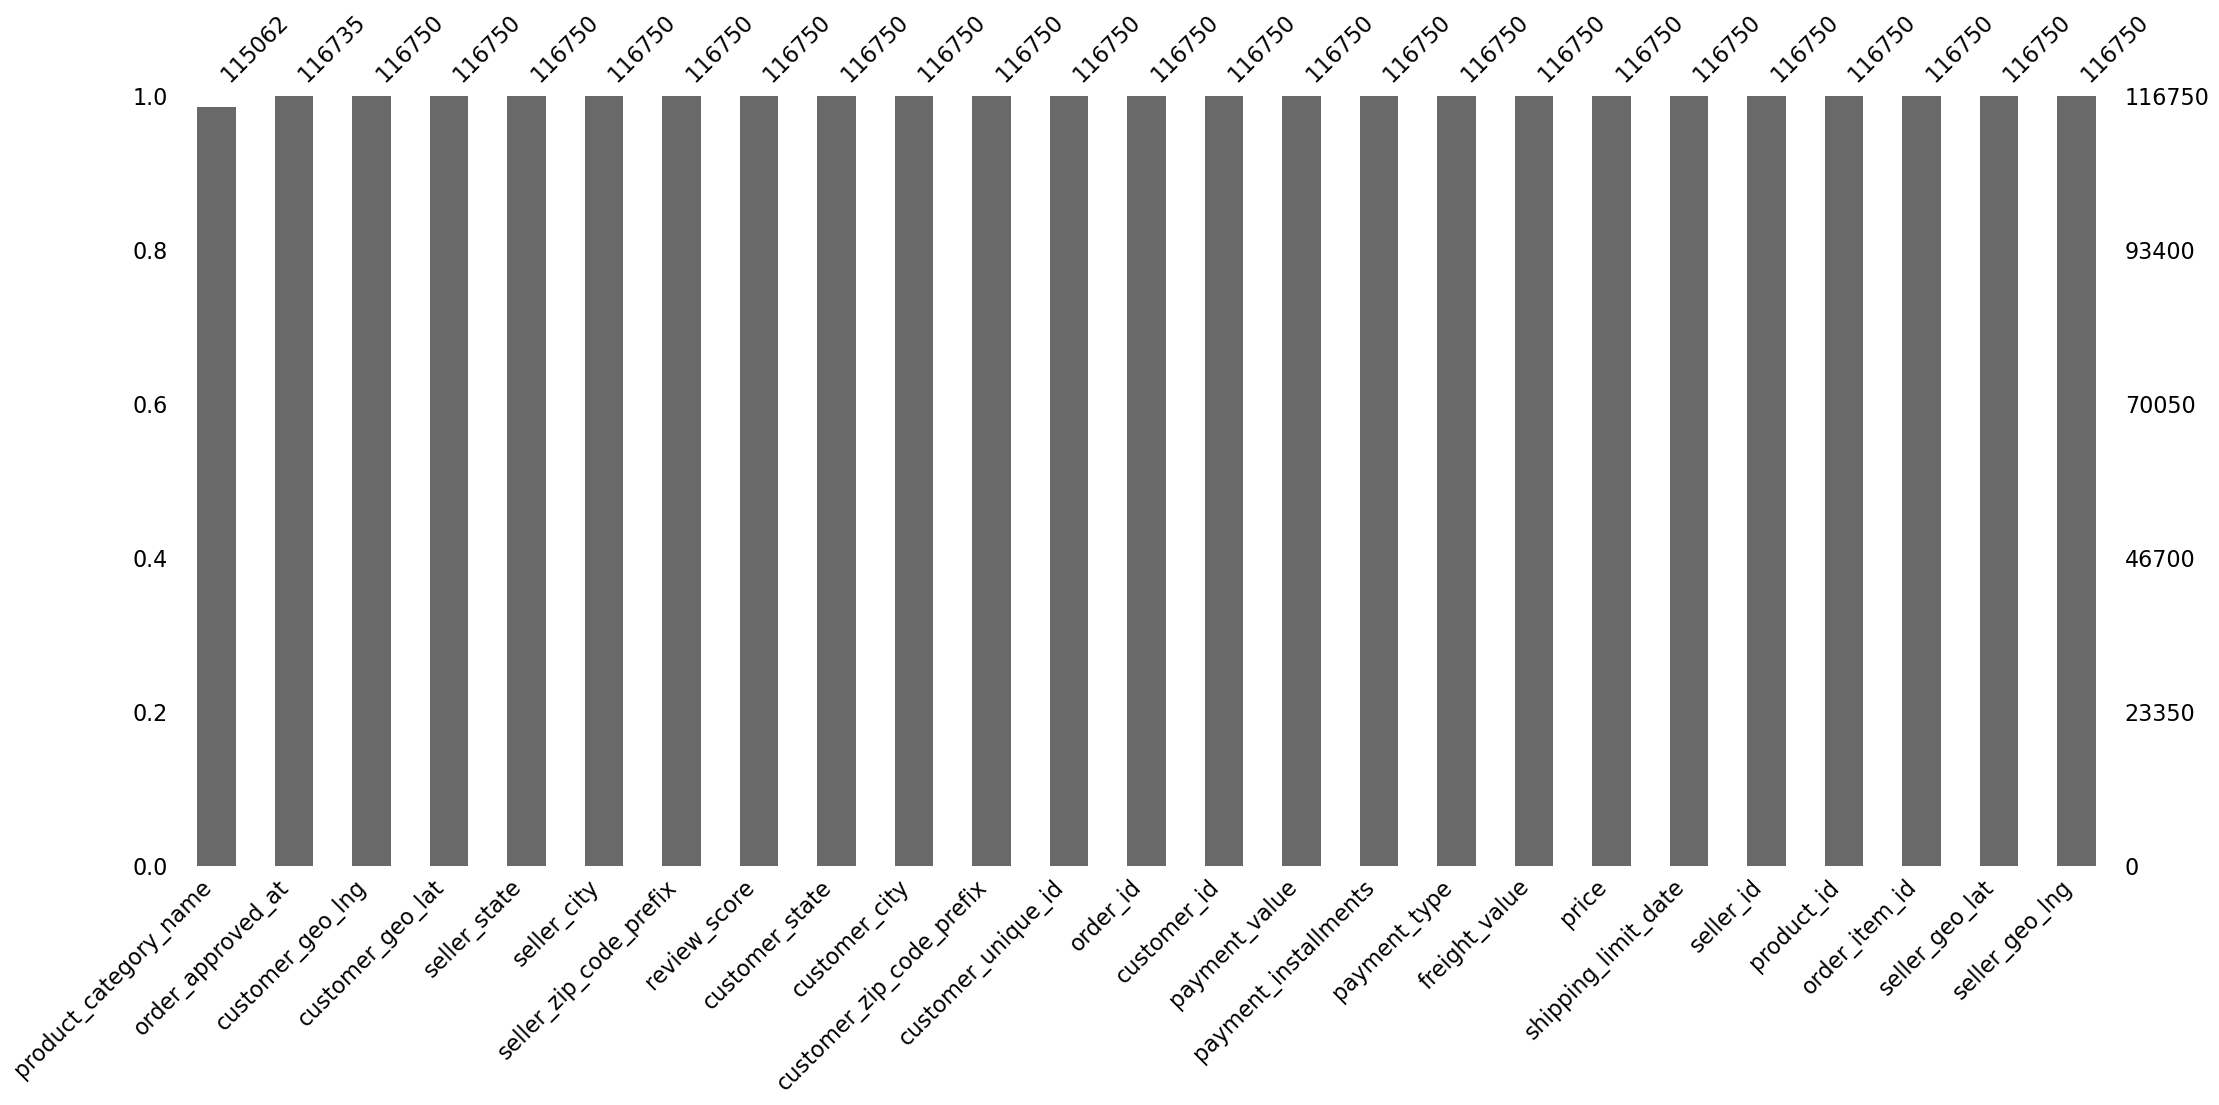

In [11]:
def valeurs_manquantes(df):
    # Identifier les valeurs manquantes
    missing_values = df.isnull().sum().sum()
    total_cells = df.size

    # Calculer le nombre de valeurs non manquantes
    non_missing_values = total_cells - missing_values

    # Calculer le pourcentage de valeurs non manquantes sur tout le jeu de données
    non_missing_percentage = (non_missing_values / total_cells) * 100

    # Calculer le pourcentage de valeurs manquantes sur tout le jeu de données
    missing_percentage = (missing_values / total_cells) * 100

    # Afficher les résultats
    print("Total des valeurs non manquantes :", non_missing_values, "soit", round(non_missing_percentage, 2), "%")
    print("Total des valeurs manquantes :", missing_values, "soit", round(missing_percentage, 2), "%")

    # Mesurer le prourcentage de NANs dans nos différentes colonnes
    missing_percentage_per_column = (df.isna().sum() / df.shape[0]) * 100
    print("\nPourcentage de valeurs manquantes par variable:")
    print(missing_percentage_per_column.apply(lambda x: f"{round(x, 2)}%"))

    # Affichage heatmap des valeurs manquantes
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(df.isna(), cbar=False)
    ax.set_title('')
    plt.show()

    # Barplot des valeurs manquantes
    mno.bar(df, sort="ascending")
    pass

#Affichage
valeurs_manquantes(df)


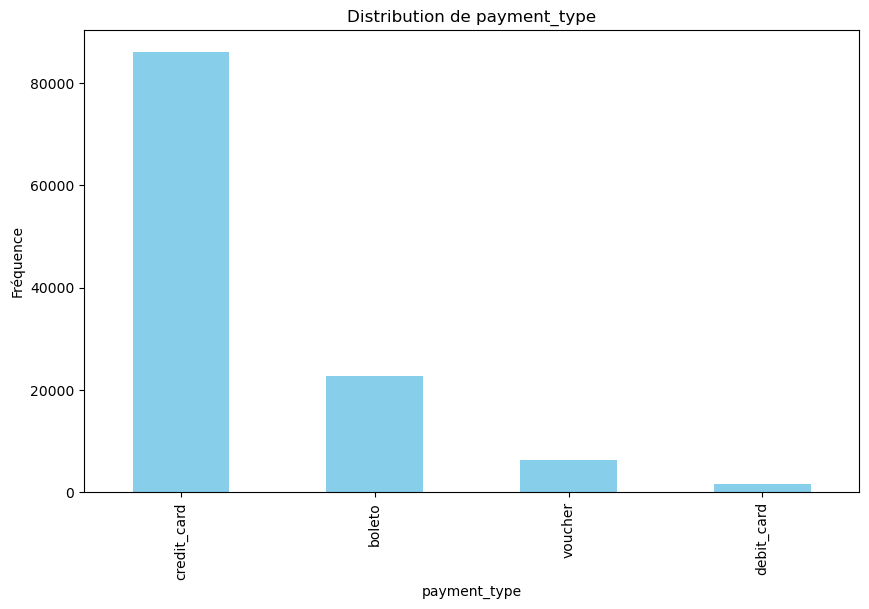

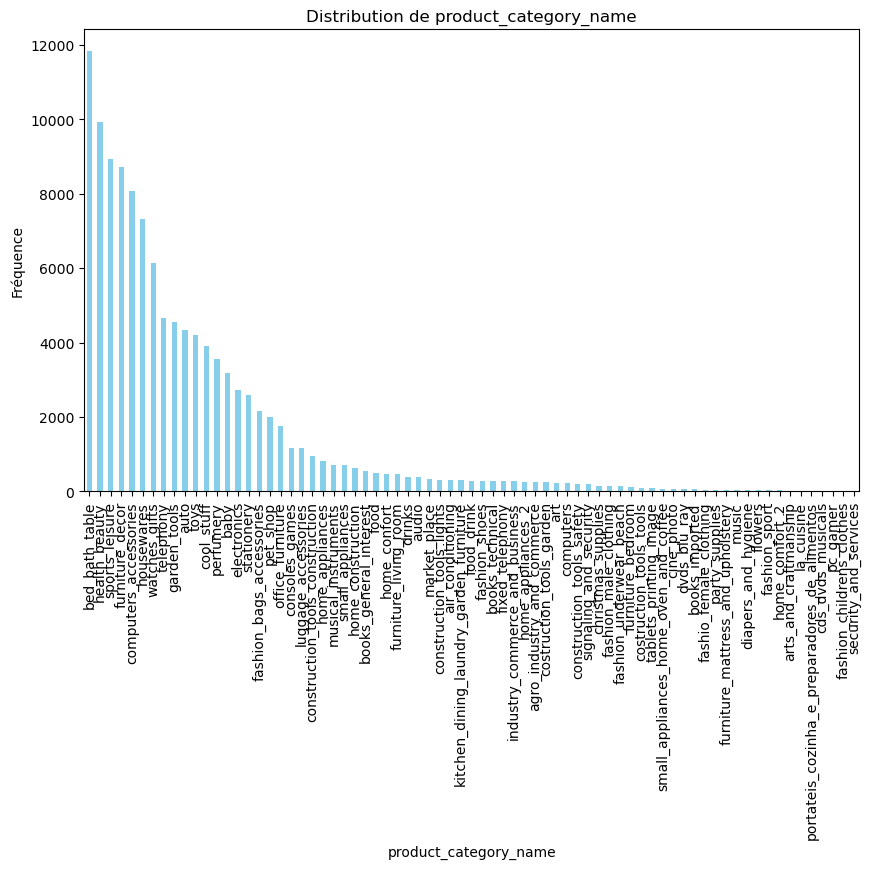

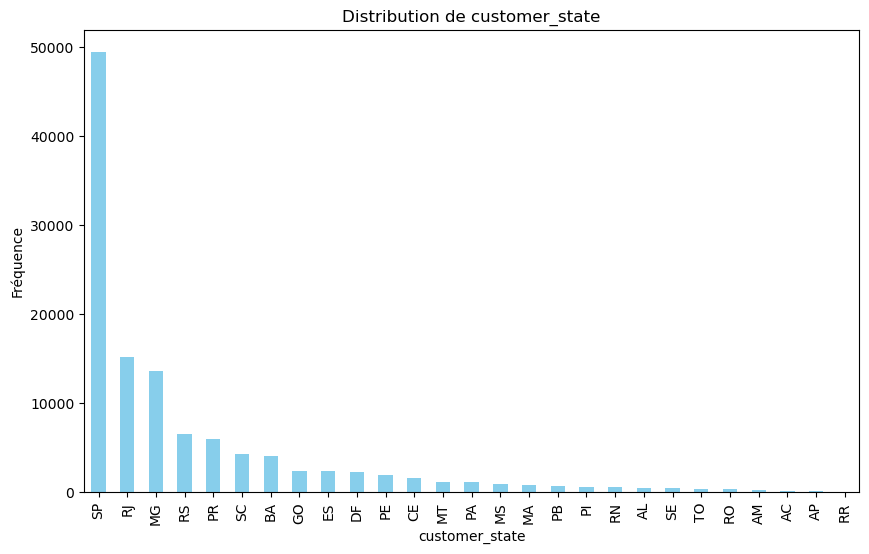

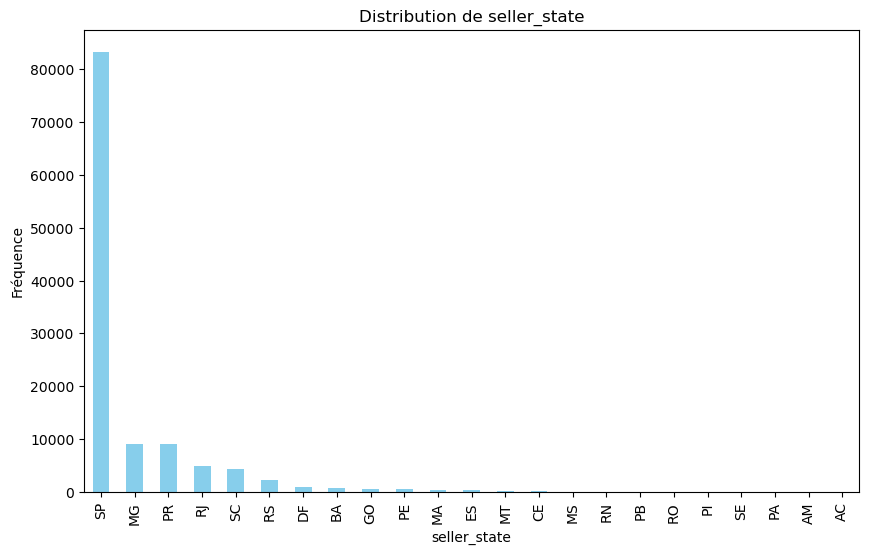

In [12]:
import matplotlib.pyplot as plt

# Sélectionnez uniquement les colonnes catégorielles
categorical_columns = [
    'payment_type','product_category_name',
    'customer_state', 'seller_state'
]

# Affichez des diagrammes à barres pour chaque colonne catégorielle
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    df[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')
    plt.xticks(rotation=90)
    plt.show()


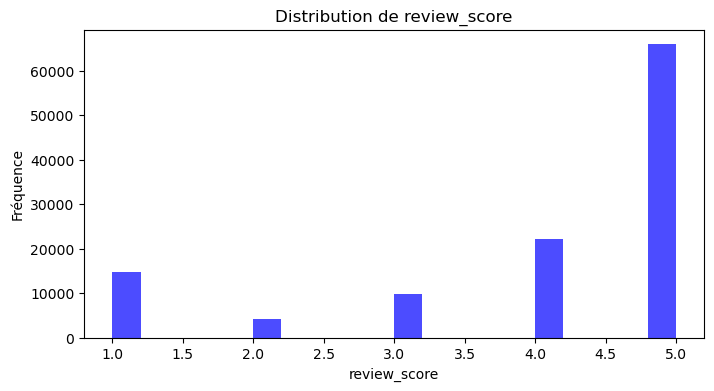

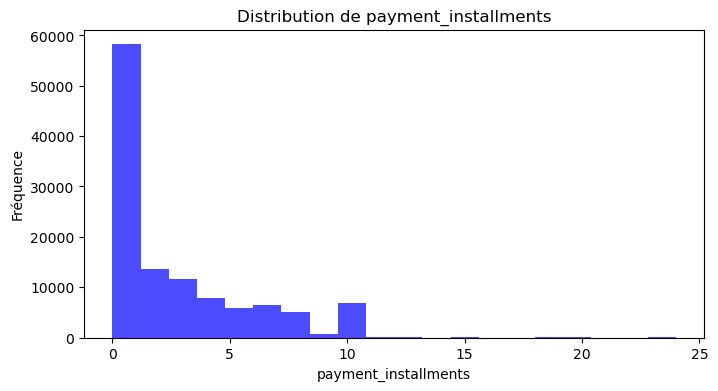

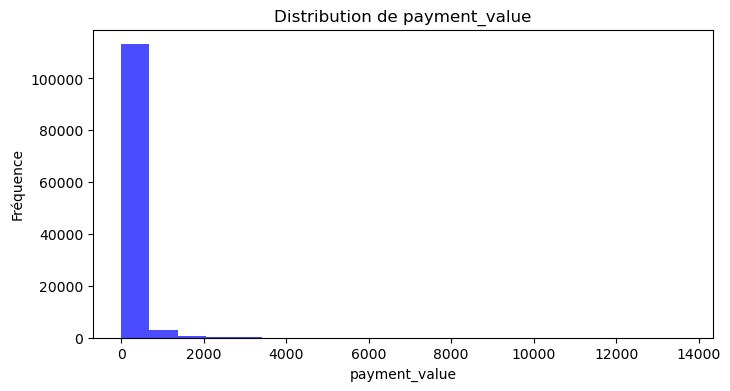

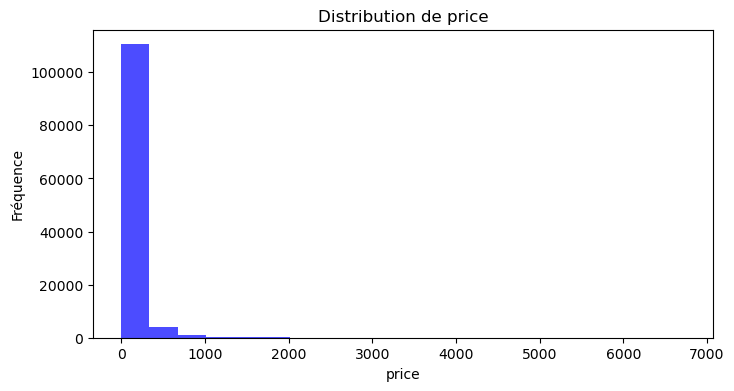

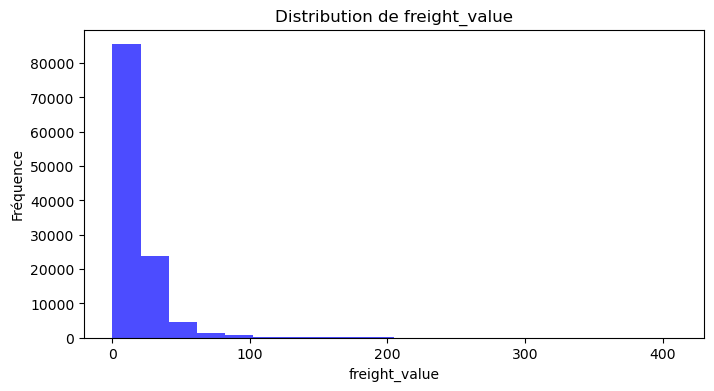

In [13]:
import matplotlib.pyplot as plt

# Sélectionnez uniquement les colonnes numériques
numeric_columns = [
    'review_score', 'payment_installments', 'payment_value', 'price',
    'freight_value'
]

# Affichez des histogrammes pour chaque colonne numérique
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[column], bins=20, color='blue', alpha=0.7)
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')
    plt.show()


## NETTOYAGE 

In [14]:
df_clean = df.copy()

In [15]:
#On supprime les colonnes qui n'ont pas d'interet pour notre analyse
df_clean.drop(['shipping_limit_date' ], axis=1, inplace=True)

In [16]:
df_clean[df_clean['order_id']=='df2d910b8b5e5f461f67043489f9569d']

order_id  order_item_id  \
9   df2d910b8b5e5f461f67043489f9569d              1   
10  df2d910b8b5e5f461f67043489f9569d              1   
11  df2d910b8b5e5f461f67043489f9569d              1   

                          product_id                         seller_id  price  \
9   4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   55.9   
10  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   55.9   
11  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   55.9   

    freight_value product_category_name payment_type  payment_installments  \
9           35.71            cool_stuff      voucher                     1   
10          35.71            cool_stuff      voucher                     1   
11          35.71            cool_stuff  credit_card                     1   

    payment_value                       customer_id    order_approved_at  \
9           20.00  2e76c1f2a920153d79cc98b634c50942  2017-06-05 14:31:21   
10          20.00  2e76c1f2a920153d79cc98b634c50942  2017-06-05 14:31:21   
11          51.61  2e76c1f2a920153d79cc98b634c50942  2017-06-05 14:31:21   

                  customer_unique_id  customer_zip_code_prefix customer_city  \
9   0efd4833752113fedce2e7250d49d5ac                     53403      paulista   
10  0efd4833752113fedce2e7250d49d5ac                     53403      paulista   
11  0efd4833752113fedce2e7250d49d5ac                     53403      paulista   

   customer_state  review_score  seller_zip_code_prefix    seller_city  \
9              PE             1                   27277  volta redonda   
10             PE             1                   27277  volta redonda   
11             PE             1                   27277  volta redonda   

   seller_state  customer_geo_lat  customer_geo_lng  seller_geo_lat  \
9            SP         -7.957872         -34.87392      -22.498183   
10           SP         -7.957872         -34.87392      -22.498183   
11           SP         -7.957872         -34.87392      -22.498183   

    seller_geo_lng  
9       -44.123614  
10      -44.123614  
11      -44.123614

In [17]:
df_clean[df_clean.duplicated()].head(10)

order_id  order_item_id  \
10   df2d910b8b5e5f461f67043489f9569d              1   
69   5a65cedc025f607cbdb4c5219f648ae3              1   
73   62e975f28aa68109d68f92298a9327ac              1   
239  2ec8ddbfe88a339d911208a26f6a8ad5              1   
379  fd2b75f431649ee3de573b444d320f48              2   
382  fd2b75f431649ee3de573b444d320f48              1   
418  f6089c47bab18faae3d90c64cfb08481              1   
603  e40ad49e77913b7176bc3268c18b3299              1   
820  f494e4f6b6de7aeefe3af00acc8b3426              1   
858  cfea19cacc7328f2fccb914fb0fd5fe2              1   

                           product_id                         seller_id  \
10   4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
69   54e5939fcd9ae70ad0f59f612d6d29bd  48436dade18ac8b2bce089ec2a041202   
73   54e5939fcd9ae70ad0f59f612d6d29bd  48436dade18ac8b2bce089ec2a041202   
239  0152f69b6cf919bcdaf117aa8c43e5a2  d2374cbcbb3ca4ab1086534108cc3ab7   
379  1d6d7be70107889e3193819aca4dc1dc  4a3ca9315b744ce9f8e9374361493884   
382  e15cee02291017f6f12b4115ffb417e6  391fc6631aebcf3004804e51b40bcf1e   
418  60525d5b6a1658c5eea3c64713922000  004c9cd9d87a3c30c522c48c4fc07416   
603  18796df281656da4036dd926561a6030  cca3071e3e9bb7d12640c9fbe2301306   
820  1aa2ed670a95e9f475723707a7c3f386  a3e9a2c700480d9bb01fba070ba80a0e   
858  39342c8e5e512bb1757779a3821a450f  4a3ca9315b744ce9f8e9374361493884   

      price  freight_value product_category_name payment_type  \
10    55.90          35.71            cool_stuff      voucher   
69    42.90           9.94            cool_stuff      voucher   
73    45.90          16.11            cool_stuff      voucher   
239   13.90          34.15        bed_bath_table      voucher   
379   48.90          11.15        bed_bath_table      voucher   
382   24.75          14.22       furniture_decor      voucher   
418  109.99          17.51        bed_bath_table  credit_card   
603   75.78          15.28        bed_bath_table  credit_card   
820   40.00          13.37        bed_bath_table  credit_card   
858  210.00          12.97        bed_bath_table  credit_card   

     payment_installments  payment_value                       customer_id  \
10                      1          20.00  2e76c1f2a920153d79cc98b634c50942   
69                      1          20.00  9eb85dfb61032b308cd9dafec6fcb3ee   
73                      1          20.49  00ba767af52461bf567696d2a6d2909f   
239                     1          20.00  39c01c306f74fd8357250244fcbe02bf   
379                     1          25.00  a5668d53c44bc380c43eb532779e0bf4   
382                     1          25.00  a5668d53c44bc380c43eb532779e0bf4   
418                     8         127.50  1521c5e9bf82979a6b8794e90692097d   
603                     5          91.06  cb786b63e7d9a15fd5cca45785ce1347   
820                     1          53.37  cef7f153f7fb65e2076d6f15e7f58f55   
858                    10         445.94  e66a1a0add343277389f32a6b9cf1a13   

       order_approved_at                customer_unique_id  \
10   2017-06-05 14:31:21  0efd4833752113fedce2e7250d49d5ac   
69   2017-09-30 11:24:47  ccd78f91a99ea36a352433913577d3ad   
73   2017-10-25 15:14:49  4dfa53e424b44b9dcb3965683078712d   
239  2018-03-02 01:10:35  577c584d4e793648664d7b39a561d6fd   
379  2018-02-22 11:48:24  3c801d053bcdee6a0d8bd452e2f54e23   
382  2018-02-22 11:48:24  3c801d053bcdee6a0d8bd452e2f54e23   
418  2017-01-31 16:25:20  92b0705c6923fe44dd71b2b737687a7c   
603  2017-10-14 11:14:30  5e1821ab07e3f73f0408a3ece0b4effa   
820  2017-06-09 19:22:11  076b7055bea51da430d6a6fa054e5075   
858  2017-05-28 20:02:34  f93ea08ded32a5b926f9dd98c1dbd61d   

     customer_zip_code_prefix          customer_city customer_state  \
10                      53403               paulista             PE   
69                      23580         rio de janeiro             RJ   
73                      39400          montes claros             MG   
239                     59390             la

In [29]:
df_clean[df_clean['product_category_name']=='divers']

order_id  order_item_id  \
613     6667ce63925742278c4eb0f5d83a913c              1   
1513    26fc240b5fd33abb402b5ccef557ec7a              1   
2061    d21d7411b251f35ead1b210dc946ca70              1   
2062    d21d7411b251f35ead1b210dc946ca70              1   
2063    d21d7411b251f35ead1b210dc946ca70              1   
2064    d21d7411b251f35ead1b210dc946ca70              1   
2065    d21d7411b251f35ead1b210dc946ca70              1   
2066    d21d7411b251f35ead1b210dc946ca70              1   
2067    d21d7411b251f35ead1b210dc946ca70              1   
2355    f0865a20899e4f5c8c93070b298ed6a3              1   
2729    cf101c3abd3c061ca9f78c1bbb1125af              1   
2730    cf101c3abd3c061ca9f78c1bbb1125af              1   
2731    cf101c3abd3c061ca9f78c1bbb1125af              1   
2732    cf101c3abd3c061ca9f78c1bbb1125af              1   
2733    cf101c3abd3c061ca9f78c1bbb1125af              1   
2734    cf101c3abd3c061ca9f78c1bbb1125af              1   
2735    cf101c3abd3c061ca9f78c1bbb1125af              1   
2736    cf101c3abd3c061ca9f78c1bbb1125af              1   
2737    cf101c3abd3c061ca9f78c1bbb1125af              1   
2738    cf101c3abd3c061ca9f78c1bbb1125af              1   
2739    cf101c3abd3c061ca9f78c1bbb1125af              1   
2740    cf101c3abd3c061ca9f78c1bbb1125af              1   
2741    cf101c3abd3c061ca9f78c1bbb1125af              1   
2821    dc3f947c4795561fca218d2ae362a4ef              1   
4248    38edd38dc17b36d7fd7554100453f1bd              1   
4352    8ac2728285fd4228f35d907768b5288a              3   
4353    8ac2728285fd4228f35d907768b5288a              3   
6374    203dbe40ec45996d84616718e573d60f              1   
7005    b1866dace5f7daf46e4ef10ed7c3a5e9              1   
7102    b11d3d0805ee25a1ca5ff9d55a65cd9d              1   
7279    717f4581cd1688ffb536d815e2636d10              1   
7476    b0aa6adc10b3bd14eae812d2f50cd2f1              1   
8204    63cb6e6a5632d2fa0406a8f3c6eae8cf              1   
8213    b4cc15026eee314f397bdfe9767a0a9e              1   
8214    e75bd2f9adb46257d65d9e916355326a              1   
8381    24ceed9729a86f5e36fd61ae94183817              1   
8382    24ceed9729a86f5e36fd61ae94183817              1   
8383    24ceed9729a86f5e36fd61ae94183817              1   
8384    24ceed9729a86f5e36fd61ae94183817              1   
8385    24ceed9729a86f5e36fd61ae94183817              1   
8386    24ceed9729a86f5e36fd61ae94183817              1   
8387    24ceed9729a86f5e36fd61ae94183817              1   
8388    24ceed9729a86f5e36fd61ae94183817              1   
8389    24ceed9729a86f5e36fd61ae94183817              1   
8442    49afe75c3c09b9e94e1456ffa5e67ff4              1   
8591    d2028724669c20a217e6146e6855cd12              1   
8713    1db2abc72703311e809fc353b3cc4b65              1   
8960    3e87545e66b02b3858e6e252413b1b8f              1   
9149    a5f429a0b94f15b78d957ff59c461c44              1   
9150    33b4e4420ddac9b1e67cc73717c9b168              1   
9257    241a31d78d0e20975a8e070a4882505a              1   
9573    f6951204d4c5a8b9721e0039ed0c894a              1   
10291   9d441bf4d514cfefd95dcfd2b22dca0e              1   
10820   ea63d003e45a23a57429b135d4595111              1   
10821   7c11eb6e7bdbdf76e17fd6cf7e1eec53              1   
12591   824abb0e495f59750ecceff64e86459c              1   
12618   ff7b636282b98e0aa524264b295ed928              1   
12755   f4ec40aeb45f082c239a842530a96294              1   
12804   c4d43ff7c0529549e6064083bd2129d3              1   
12916   807756ebd577f025334944b87da7dbc3              1   
12920   36a2993f853a2f6132cdda1475bf2acb              1   
12934   626f6424e635c6341bfddf7d53bf3746              1   
12958   cd452825757203504f7c8c7ddd201907              1   
13348   e22b71f6e4a481445ec4527cb4c405f7              1   
13355   563d936ee2d2defb115a6eadf4a7d65f              1   
13357   6ae15c99eca2bc6444d358fd9f44e5bf              1   
13385   43c564b825003473af9a68138631d388              1   
13390   17fe10145119

In [18]:
# On remplace toutes les NANs product_category_name divers
df_clean['product_category_name'].fillna('divers', inplace=True)


#### Aprés avoir recherché les id des produits, aucun nom de produit ne resort donc on les classes dans divers pour evité de les supprimers.

In [19]:
df_cleaned = df_clean.copy()

## Analyse

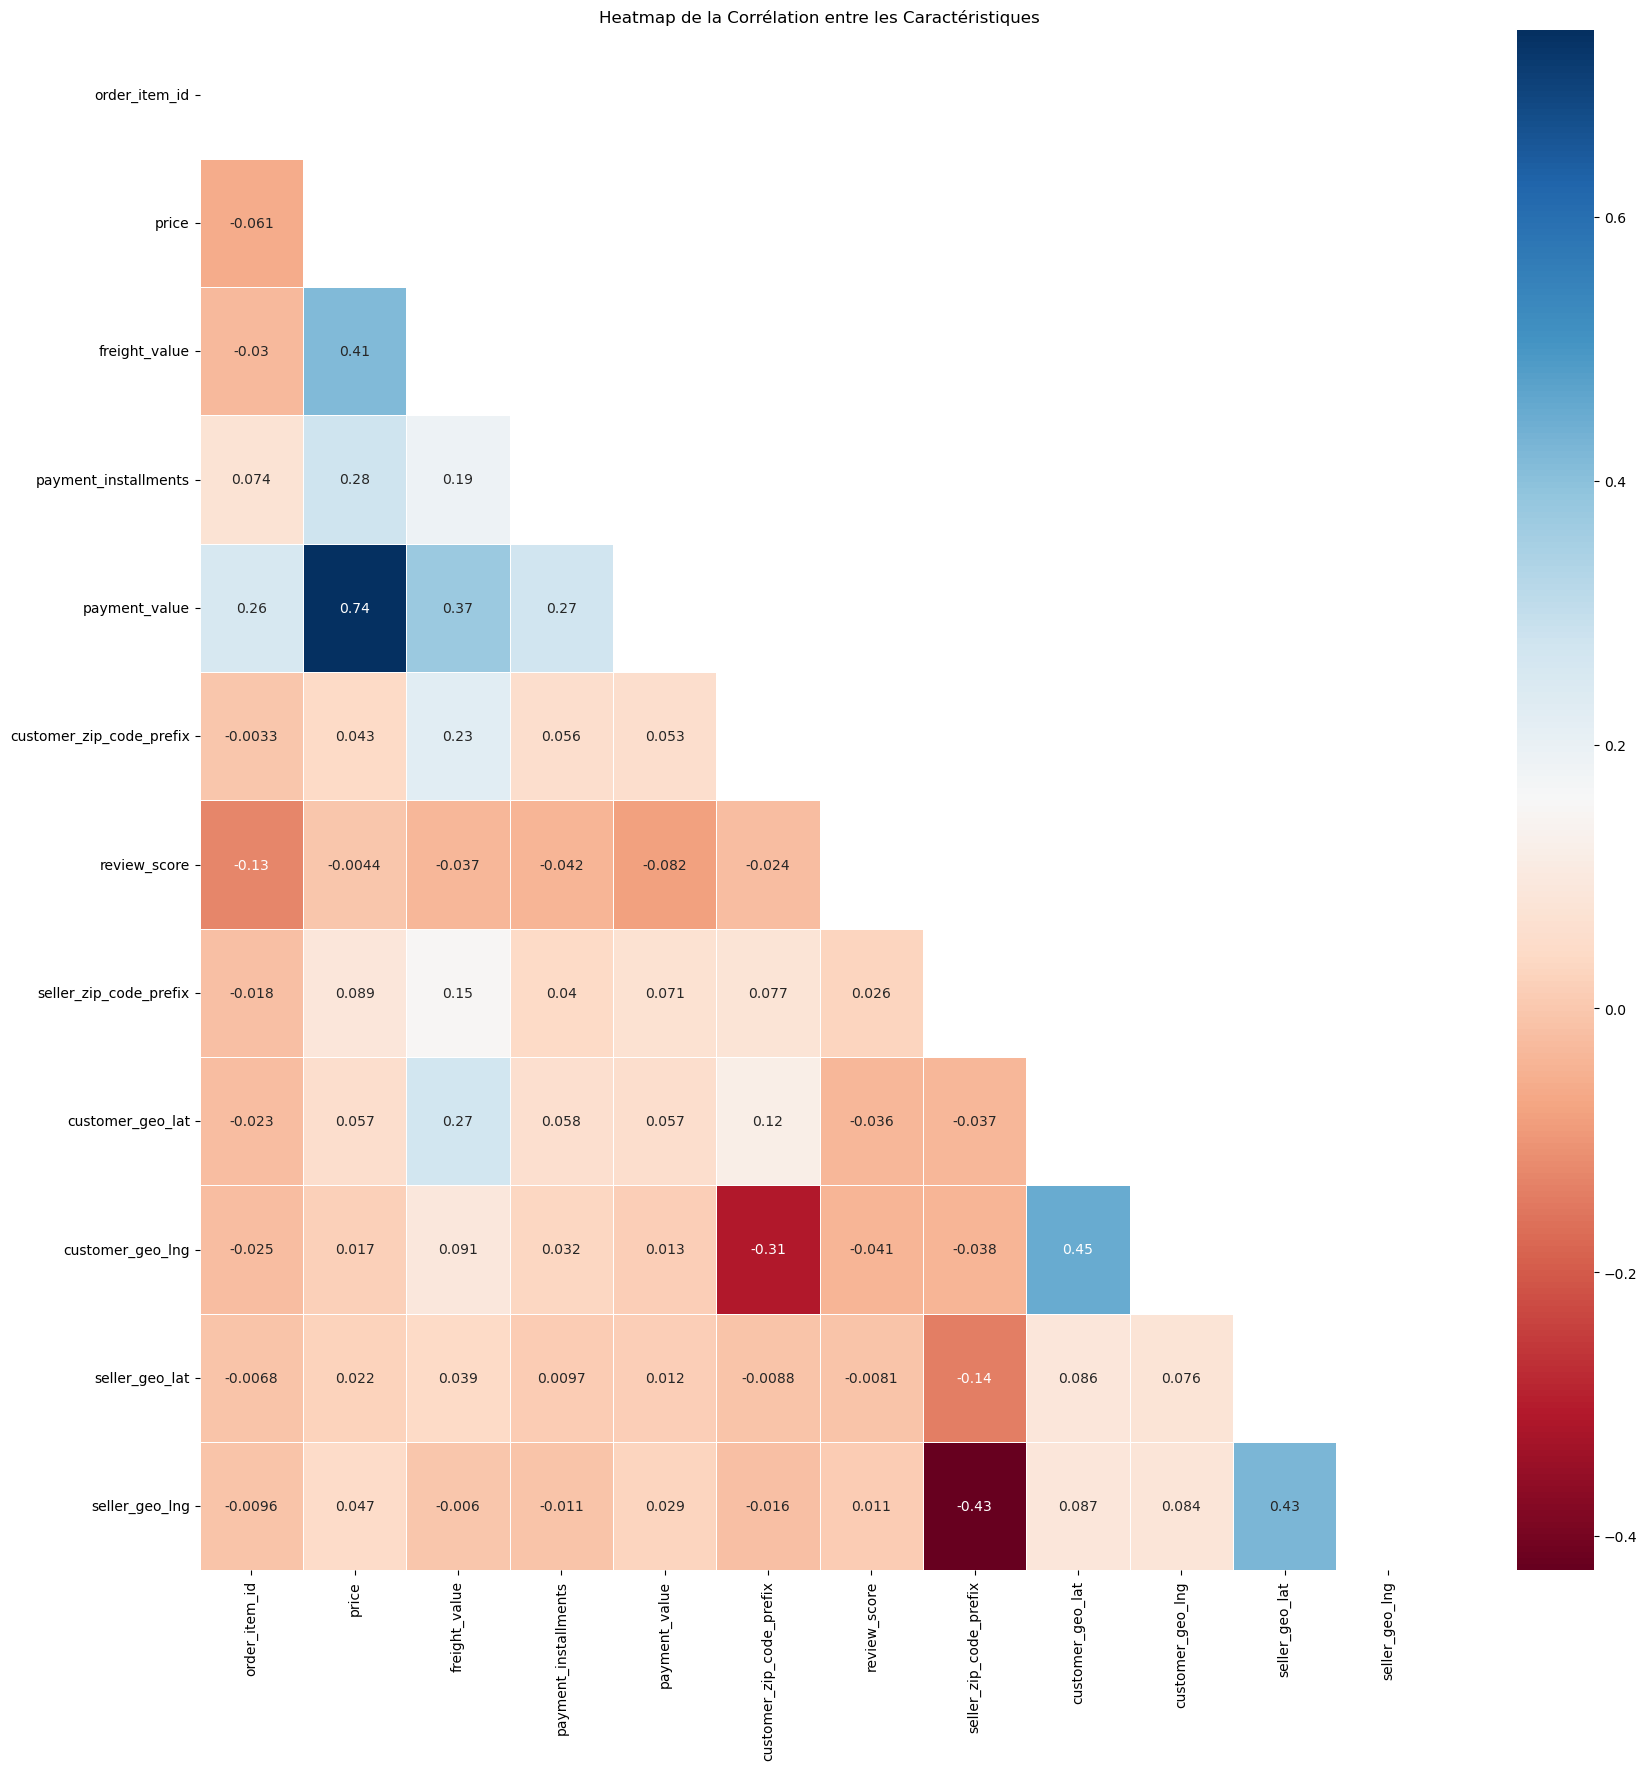

In [20]:
# Créer une heatmap
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(df_cleaned.corr()))
sns.heatmap(df_cleaned.corr(), cmap='RdBu' ,annot=True,mask=mask, linewidths=.5)
plt.title('Heatmap de la Corrélation entre les Caractéristiques')
plt.show()
pass


In [21]:


# Changement du type de 'order_approved_at' au format datetime
df_cleaned['order_approved_at'] = pd.to_datetime(df_cleaned['order_approved_at'])

# Tri du DataFrame par 'order_approved_at' pour garantir l'ordre chronologique
df_cleaned = df_cleaned.sort_values(by=['order_approved_at'])

# Calcul de la durée écoulée entre deux commandes pour chaque client
df_cleaned['time_between_orders_same_customer'] = df_cleaned.groupby('customer_unique_id')['order_approved_at'].diff()

# Remplacer les valeurs négatives par 0
df_cleaned['time_between_orders_same_customer'] = df_cleaned['time_between_orders_same_customer'].apply(lambda x: max(pd.Timedelta(seconds=0), x))

# Extraction du nombre de jours et d'heures
df_cleaned['days_between_orders_same_customer'] = df_cleaned['time_between_orders_same_customer'].dt.days
df_cleaned['hours_between_orders_same_customer'] = df_cleaned['time_between_orders_same_customer'].dt.seconds // 3600

# Calcul de la durée écoulée entre chaque 'order_approved_at'
df_cleaned['time_between_orders_all'] = df_cleaned['order_approved_at'].diff()

# Remplacer les valeurs négatives par 0
df_cleaned['time_between_orders_all'] = df_cleaned['time_between_orders_all'].apply(lambda x: max(pd.Timedelta(seconds=0), x))

# Extraction du nombre de jours et d'heures entre chaque 'order_approved_at'
df_cleaned['days_between_orders_all'] = df_cleaned['time_between_orders_all'].dt.days
df_cleaned['hours_between_orders_all'] = df_cleaned['time_between_orders_all'].dt.seconds // 3600

# Affichage des résultats
print("Analyses pour les commandes du même client:")
print(f"Durée moyenne entre deux commandes par client : {df_cleaned['time_between_orders_same_customer'].mean()}")
print(f"Durée minimale entre deux commandes par client : {df_cleaned['time_between_orders_same_customer'].min()}")
print(f"Durée maximale entre deux commandes par client : {df_cleaned['time_between_orders_same_customer'].max()}")

print("\nAnalyses pour toutes les commandes:")
print(f"Durée moyenne entre toutes les commandes : {df_cleaned['time_between_orders_all'].mean()}")
print(f"Durée minimale entre toutes les commandes : {df_cleaned['time_between_orders_all'].min()}")
print(f"Durée maximale entre toutes les commandes : {df_cleaned['time_between_orders_all'].max()}")


Analyses pour les commandes du même client:
Durée moyenne entre deux commandes par client : 2 days 03:32:26.336102783
Durée minimale entre deux commandes par client : 0 days 00:00:00
Durée maximale entre deux commandes par client : 613 days 13:17:46

Analyses pour toutes les commandes:
Durée moyenne entre toutes les commandes : 0 days 00:08:37.534852248
Durée minimale entre toutes les commandes : 0 days 00:00:00
Durée maximale entre toutes les commandes : 71 days 02:22:31


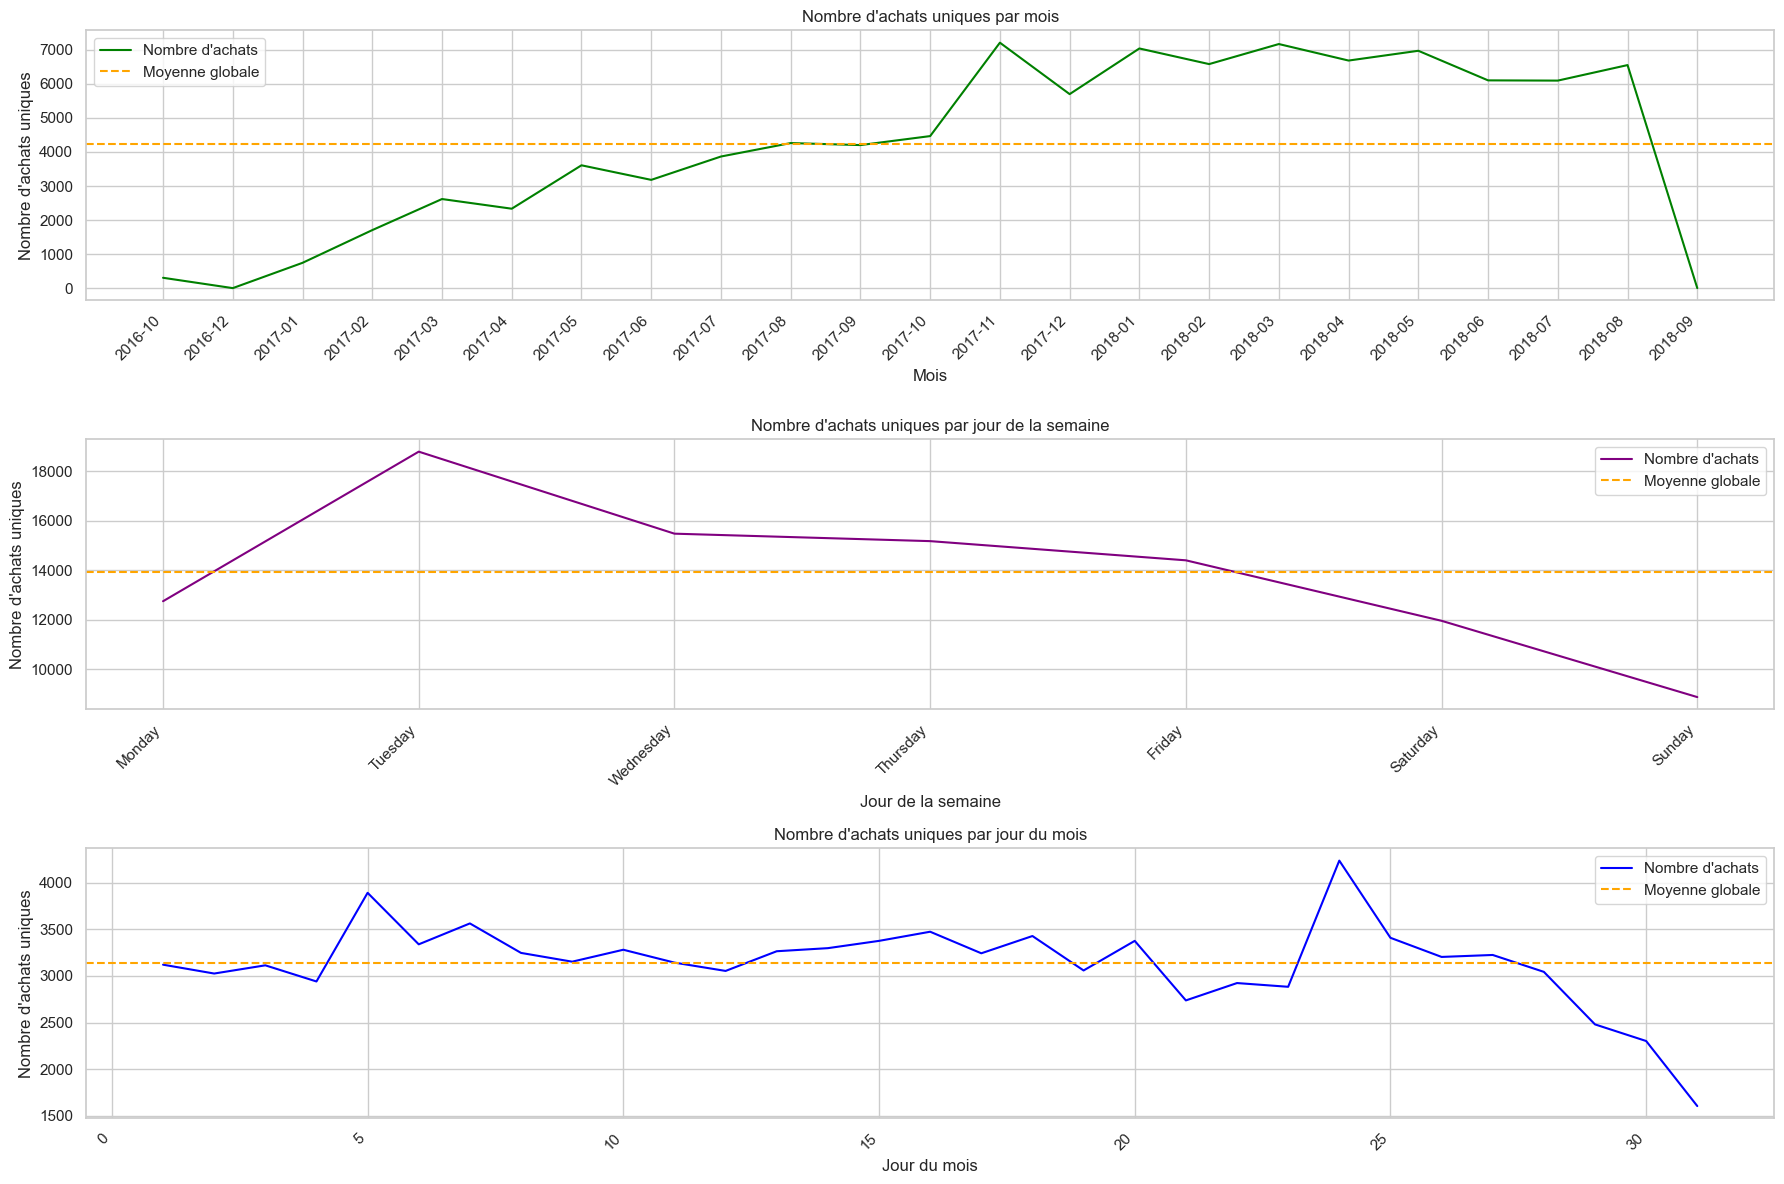

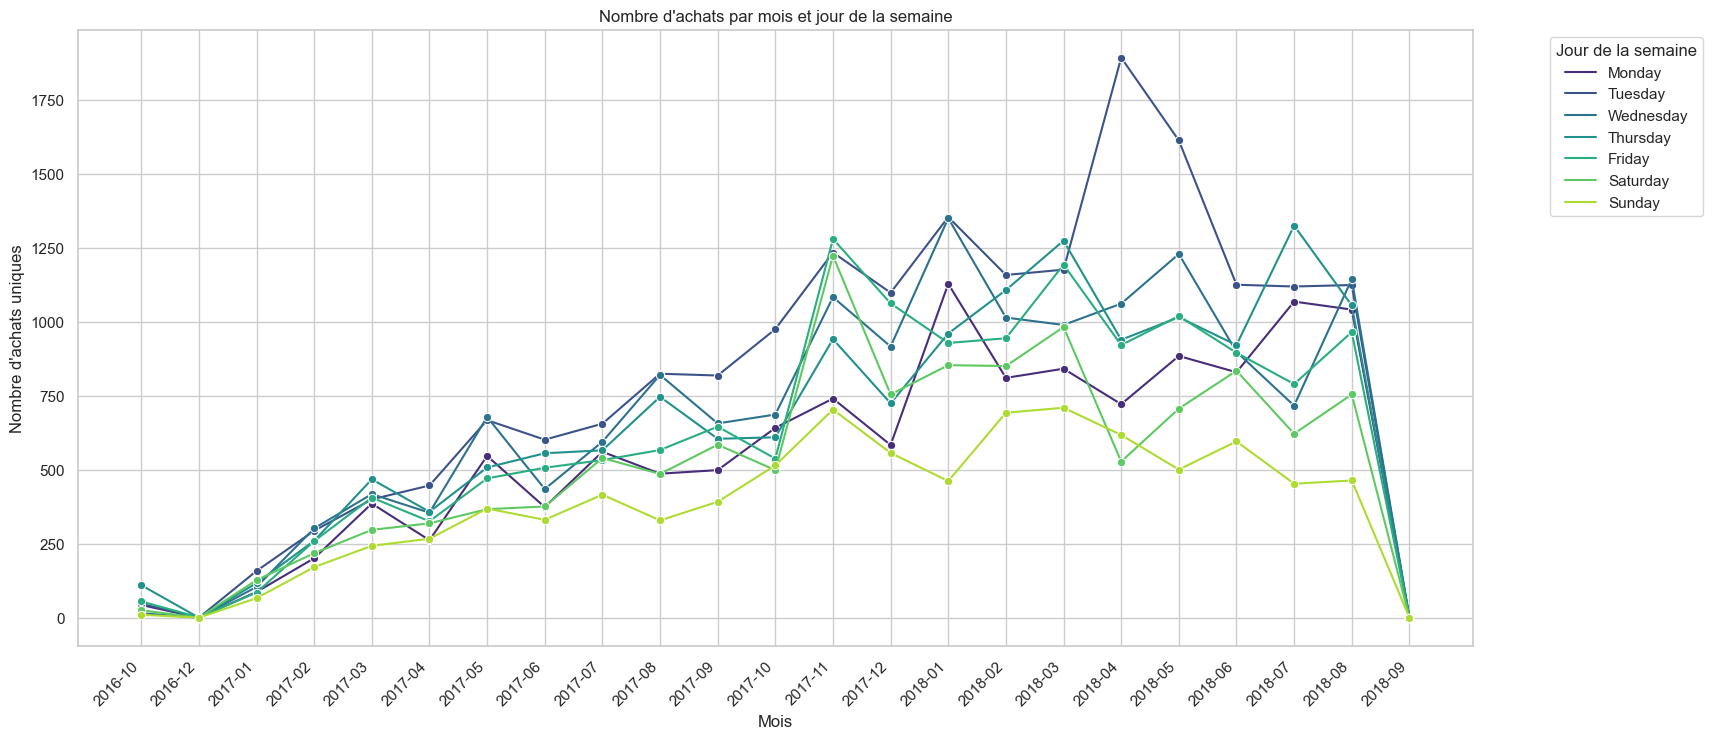

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Changement du type de 'order_approved_at' au format datetime
df_cleaned['order_approved_at'] = pd.to_datetime(df_cleaned['order_approved_at'])

# Création d'une nouvelle colonne pour extraire le mois, le jour de la semaine et le jour du mois
df_cleaned['order_month'] = df_cleaned['order_approved_at'].dt.to_period('M')
df_cleaned['day_of_week'] = df_cleaned['order_approved_at'].dt.day_name()

# Spécifier l'ordre des jours de la semaine
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_cleaned['day_of_week'] = pd.Categorical(df_cleaned['day_of_week'], categories=day_order, ordered=True)

df_cleaned['day_of_month'] = df_cleaned['order_approved_at'].dt.day

# Groupement par mois et calcul du nombre d'achats uniques par mois
orders_per_month = df_cleaned.groupby('order_month')['order_id'].nunique()

# Groupement par jour de la semaine et calcul du nombre d'achats uniques par jour de la semaine
orders_per_day_of_week = df_cleaned.groupby('day_of_week')['order_id'].nunique()

# Groupement par jour du mois et calcul du nombre d'achats uniques par jour du mois
orders_per_day_of_month = df_cleaned.groupby('day_of_month')['order_id'].nunique()

# Calcul de la moyenne du nombre d'achats par période
avg_orders_per_month = orders_per_month.mean()
avg_orders_per_day_of_week = orders_per_day_of_week.mean()
avg_orders_per_day_of_month = orders_per_day_of_month.mean()

# Utilisation de seaborn pour un style plus élégant
sns.set(style="whitegrid")

# Création des graphiques
plt.figure(figsize=(18, 12))

# Graphique par mois
plt.subplot(3, 1, 1)
sns.lineplot(x=orders_per_month.index.astype(str), y=orders_per_month.values, color='green', label='Nombre d\'achats')
plt.axhline(y=avg_orders_per_month, color='orange', linestyle='--', label='Moyenne globale')
plt.title('Nombre d\'achats uniques par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'achats uniques')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Graphique par jour de la semaine
plt.subplot(3, 1, 2)
sns.lineplot(x=orders_per_day_of_week.index, y=orders_per_day_of_week.values, color='purple', label='Nombre d\'achats')
plt.axhline(y=avg_orders_per_day_of_week, color='orange', linestyle='--', label='Moyenne globale')
plt.title('Nombre d\'achats uniques par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre d\'achats uniques')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Graphique par jour du mois
plt.subplot(3, 1, 3)
sns.lineplot(x=orders_per_day_of_month.index, y=orders_per_day_of_month.values, color='blue', label='Nombre d\'achats')
plt.axhline(y=avg_orders_per_day_of_month, color='orange', linestyle='--', label='Moyenne globale')
plt.title('Nombre d\'achats uniques par jour du mois')
plt.xlabel('Jour du mois')
plt.ylabel('Nombre d\'achats uniques')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Ajustement du format du graphique
plt.tight_layout()
plt.show()


# Utilisation de seaborn pour un style plus élégant
sns.set(style="whitegrid")

# Création du graphique
plt.figure(figsize=(18, 8))

# Graphique à barres empilées pour chaque jour de la semaine dans chaque mois
sns.lineplot(x=orders_per_month_day_of_week['order_month'].astype(str), y=orders_per_month_day_of_week['order_id'], hue=orders_per_month_day_of_week['day_of_week'], palette='viridis', marker='o')

# Ajustements esthétiques
plt.title('Nombre d\'achats par mois et jour de la semaine')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'achats uniques')

# Ajustement du format du graphique
plt.xticks(rotation=45, ha='right')
plt.legend(title='Jour de la semaine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [23]:
from geopy.distance import geodesic

# Fonction lambda pour calculer la distance géographique entre le client et le vendeur
df_cleaned['distance'] = df_cleaned.apply(lambda row: geodesic((row['customer_geo_lat'], row['customer_geo_lng']),
                                                           (row['seller_geo_lat'], row['seller_geo_lng'])).km, axis=1)


In [24]:
import pandas as pd
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, AwesomeIcon
import random

# Grouper par 'seller_state' pour obtenir le nombre total d'articles vendus par état
total_articles_sold_per_state = df_cleaned.groupby('seller_state')['order_item_id'].count().to_dict()

# Grouper par 'customer_state' pour obtenir le nombre total d'articles achetés par état
total_articles_purchased_per_state = df_cleaned.groupby('customer_state')['order_item_id'].count().to_dict()

# Créer une carte centrée sur le Brésil
m = Map(center=(-14.235, -51.925), zoom=4)

# Ajouter des marqueurs pour chaque état avec le nombre total d'articles vendus
for state, total_articles_sold in total_articles_sold_per_state.items():
    # Générer une couleur aléatoire pour chaque marqueur de vente
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Créer une icône avec la couleur spécifiée pour les ventes
    sales_icon = AwesomeIcon(name='check-circle', marker_color='white', icon_color=color, spin=False)
    
    # Ajouter le marqueur de vente
    sales_marker = Marker(location=(df_cleaned.loc[df['seller_state'] == state, 'seller_geo_lat'].mean(),
                                    df_cleaned.loc[df['seller_state'] == state, 'seller_geo_lng'].mean()),
                          title=f"État: {state}\nNombre total d'articles vendus : {total_articles_sold}",
                          draggable=False,
                          icon=sales_icon)
    m.add_layer(sales_marker)

# Ajouter des marqueurs pour chaque état avec le nombre total d'articles achetés
for state, total_articles_purchased in total_articles_purchased_per_state.items():
    # Générer une couleur aléatoire pour chaque marqueur d'achat
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Créer une icône avec la couleur spécifiée pour les achats
    purchases_icon = AwesomeIcon(name='times-circle', marker_color='white', icon_color=color, spin=False)
    
    # Ajouter le marqueur d'achat
    purchases_marker = Marker(location=(df_cleaned.loc[df['customer_state'] == state, 'customer_geo_lat'].median(),
                                        df_cleaned.loc[df['customer_state'] == state, 'customer_geo_lng'].median()),
                              title=f"État: {state}\nNombre total d'articles achetés : {total_articles_purchased}",
                              draggable=False,
                              icon=purchases_icon)
    m.add_layer(purchases_marker)

# Utiliser un fond de carte (basemap) plus clair
openstreetmap_layer = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
m.add_layer(openstreetmap_layer)

# Afficher la carte interactive
m


Map(center=[-14.235, -51.925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [25]:
# Fonction lambda pour vérifier si la livraison est gratuite
df_clean['free_shipping'] = df_clean.apply(lambda row: True if row['freight_value'] == 0 else False, axis=1)

# Fonction lambda pour calculer le montant moyen par paiement installé
avg_payment_per_installment = df_clean.apply(lambda row: row['payment_value'] / row['payment_installments'] if row['payment_installments'] > 0 else 0, axis=1).mean()

# Affichage
print('le montant moyen par paiement installé est :',avg_payment_per_installment)

le montant moyen par paiement installé est : 90.19506170381567


In [26]:
# Calcul du pourcentage de livraisons gratuites et payantes
shipping_counts = df_clean['free_shipping'].value_counts()
percentage_free = (shipping_counts[True] / len(df_clean)) * 100
percentage_paid = (shipping_counts[False] / len(df_clean)) * 100

print(f"Pourcentage de livraisons gratuites : {percentage_free:.2f}%")
print(f"Pourcentage de livraisons payantes : {percentage_paid:.2f}%")

shipping_counts

Pourcentage de livraisons gratuites : 0.33%
Pourcentage de livraisons payantes : 99.67%


False    116362
True        388
Name: free_shipping, dtype: int64

In [27]:
df_cleaned.head()

order_id  order_item_id  \
80619   1ff217aa612f6cd7c4255c9bfe931c8b              1   
102840  65d1e226dfaeb8cdc42f665422522d14              1   
70820   cd3b8574c82b42fc8129f6d502690c3e              1   
65554   ed8c7b1b3eb256c70ce0c74231e1da88              1   
960     d207cc272675637bfed0062edffd0818              1   

                              product_id                         seller_id  \
80619   33430c5c1027d812b5c62f778e5ee7f7  4b1eaadf791bdbbad8c4a35b65236d52   
102840  9c7bdf67b06b419aefb93cfdfc96c55d  ed49da7cadefc454d6a67de249eab240   
70820   e2a1d45a73dc7f5a7f9236b043431b89  b499c00f28f4b7069ff6550af8c1348a   
65554   29bedbfbe73ea473396306b4f0c010ec  5b179e9e8cc7ab6fd113a46ca584da81   
960     107177bf61755f05c604fe57e02467d6  cca3071e3e9bb7d12640c9fbe2301306   

         price  freight_value product_category_name payment_type  \
80619    32.49          11.74        consoles_games  credit_card   
102840   21.50          14.11        sports_leisure  credit_card   
70820    29.99          10.96         fashion_shoes  credit_card   
65554    89.90          24.87            housewares  credit_card   
960     119.90          13.56       furniture_decor  credit_card   

        payment_installments  payment_value                       customer_id  \
80619                      2          44.23  b3a9bf200375f53cc5c6991919c356fd   
102840                     1          35.61  70fc57eeae292675927697fe03ad3ff5   
70820                      4          40.95  7812fcebfc5e8065d31e1bb5f0017dae   
65554                      1         114.77  da0ba2a9935bca5b4610b0e3bca9d3b4   
960                        6         133.46  b8cf418e97ae795672d326288dfab7a7   

         order_approved_at                customer_unique_id  \
80619  2016-10-04 09:43:32  14359ea0c7a105749c0a56478825b015   
102840 2016-10-04 10:18:57  b8b8726af116a5cfb35b0315ecef9172   
70820  2016-10-04 10:19:23  87776adb449c551e74c13fc34f036105   
65554  2016-10-04 10:25:46  88bc832f104b6dd684a17dbb1b76e778   
960    2016-10-04 10:28:07  8d3a54507421dbd2ce0a1d58046826e0   

        customer_zip_code_prefix   customer_city customer_state  review_score  \
80619                       4849       sao paulo             SP             5   
102840                     22770  rio de janeiro             RJ             1   
70820                      12030         taubate             SP             5   
65554                       2993       sao paulo             SP             1   
960                        13185     hortolandia             SP             1   

        seller_zip_code_prefix     seller_city seller_state  customer_geo_lat  \
80619                    14092  ribeirao preto           SP        -23.740974   
102840                    5571       sao paulo           SP        -22.938628   
70820                    13481         limeira           SP        -23.036952   
65554                     5424       sao paulo           SP        -23.454810   
960                      14940        ibitinga           SP        -22.904356   

        customer_geo_lng  seller_geo_lat  seller_geo_lng  \
80619         -46.670188      -21.174925      -47.768616   
102840        -43.360653      -23.592660      -46.797040   
70820         -45.569976      -22.599254      -47.379810   
65554         -46.735505      -23.571258      -46.696331   
960           -47.175502      -21.766477      -48.831547   

       time_between_orders_same_customer  days_between_orders_same_customer  \
80619                             0 days                                  0   
102840                            0 days                                  0   
70820                             0 days                                  0   
65554                             0 days                                  0   
960                               0 days                                  0   

        hours_between_orders_same_customer time_between_orders_all  \
80619                                    0     

Total des valeurs non manquantes : 3969440 soit 100.0 %
Total des valeurs manquantes : 60 soit 0.0 %

Pourcentage de valeurs manquantes par variable:
order_id                               0.0%
order_item_id                          0.0%
product_id                             0.0%
seller_id                              0.0%
price                                  0.0%
freight_value                          0.0%
product_category_name                  0.0%
payment_type                           0.0%
payment_installments                   0.0%
payment_value                          0.0%
customer_id                            0.0%
order_approved_at                     0.01%
customer_unique_id                     0.0%
customer_zip_code_prefix               0.0%
customer_city                          0.0%
customer_state                         0.0%
review_score                           0.0%
seller_zip_code_prefix                 0.0%
seller_city                            0.0%
seller_state  

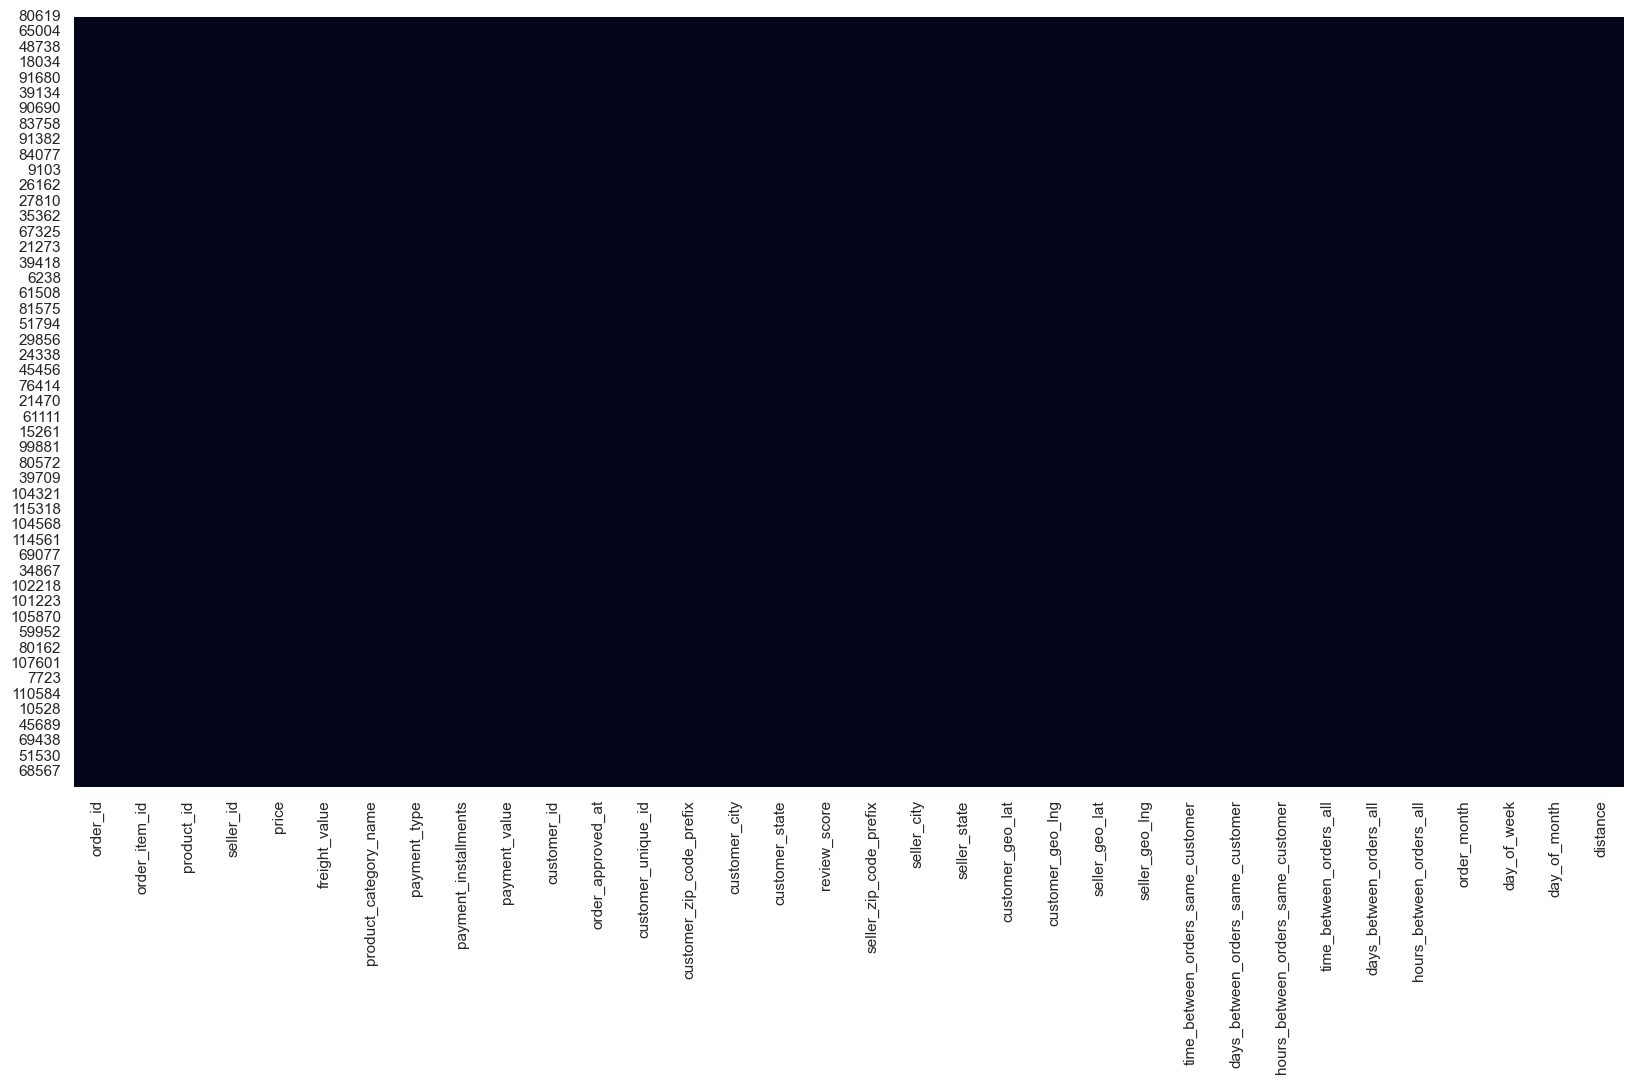

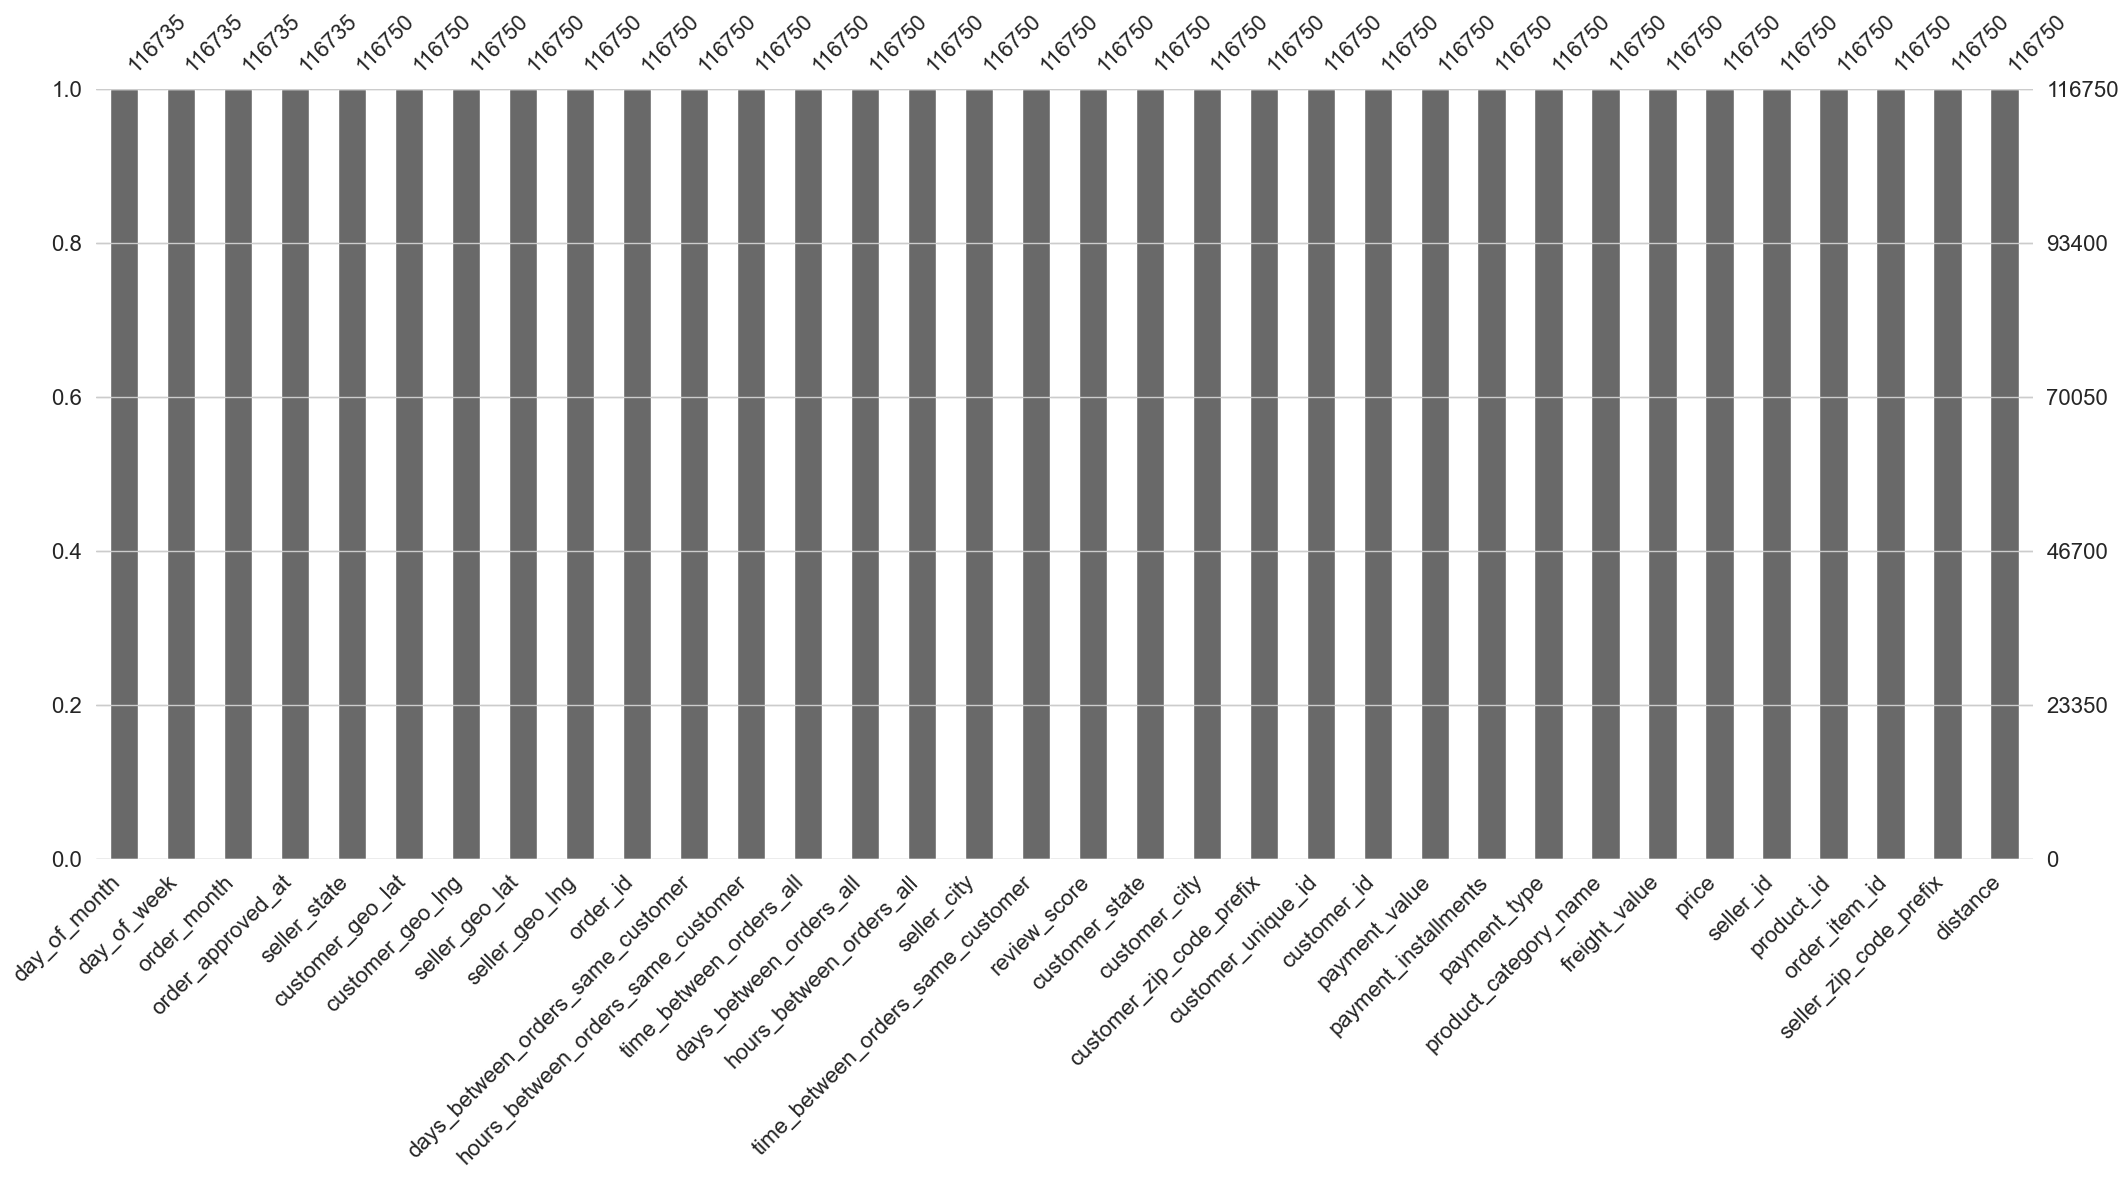

In [30]:
valeurs_manquantes(df_cleaned)


In [31]:
df_cleaned.shape

(116750, 34)

# Enregistrement

In [25]:
import joblib

# Enregistrez le DataFrame dans un fichier Joblib
joblib.dump(df_cleaned, 'df_cleaned.joblib')




['df_cleaned.joblib']